# **Comparison between 3 Computer Vision models**

chapter 3: **PyTorch Computer Vision**

https://www.youtube.com/watch?v=Z_ikDlimN6A

# Setup

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import torchmetrics
from torchmetrics import ConfusionMatrix

import mlxtend # >= 0.19
from mlxtend.plotting import plot_confusion_matrix

import random
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from timeit import default_timer as timer 

print(
f''' 
All modules are installed correctly

PyTorch: {torch.__version__}
TorchVision: {torchvision.__version__}
TorchMetrics: {torchmetrics.__version__}
MLxtend: {mlxtend.__version__}
'''
)

# Check MLextend version
assert int(mlxtend.__version__.split(".")[1]) >= 19, "\nMLxtend version should be 0.19.0 or higher"

 
All modules are installed correctly

PyTorch: 1.12.1+cu113
TorchVision: 0.13.1+cu113
TorchMetrics: 0.10.2
MLxtend: 0.21.0



In [14]:
# Hyperparameters
SEED = 42
EPOCHS = 4
HIDDEN = 10
WIDTH = 28
HEIGHT = 28
BATCH_SIZE = 32
LEARNING_RATE = 0.1
print("All hyperparaneters are defined correctly")

All hyperparaneters are defined correctly


In [15]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")
!nvidia-smi

Using device: cpu

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Data Preparation

In [16]:
# Get train data from FashionMNIST
train_data = datasets.FashionMNIST(
    root="data", 
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None 
)

# Get test data from FashionMNIST
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

print(
f'''
Training Data:
{train_data}

Testing Data:
{test_data}
'''
)


Training Data:
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Testing Data:
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()



In [18]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

## Data visualization

Image shape: torch.Size([1, 28, 28])



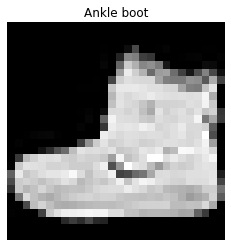

In [19]:
# visualize first image in the dataset
image, label = train_data[0]
print(f"Image shape: {image.shape}\n")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis(False);

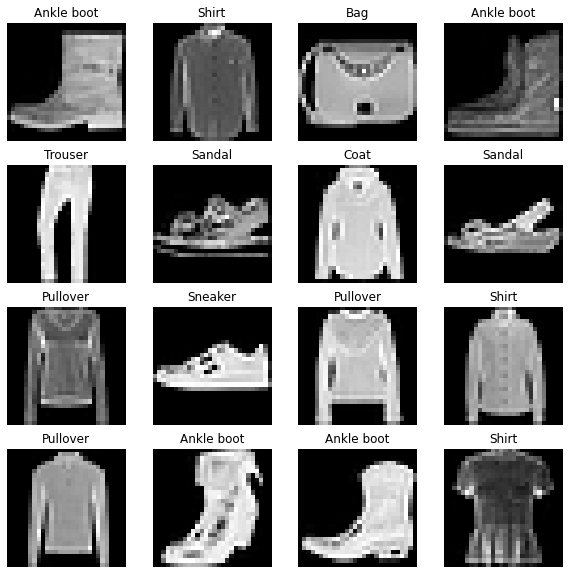

In [20]:
# Plot 16 random images from our dataset
fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
torch.manual_seed(SEED)

for i in range(1, rows*cols+1):

    # get a random index
    random_idx = torch.randint(0, len(train_data), size=[1]).item()

    # get image and lable from index
    img, label = train_data[random_idx]

    # add image to subplot in grayscale
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## Dataloader

In [21]:
# Turn dataloaders into iterables

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(
f'''
DataLoaders:
{train_dataloader}
{test_dataloader}

Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}
Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}

Shape of train_features (batch): {train_features_batch.shape}
Shape of train_labels (batch): {train_labels_batch.shape}
'''
)


DataLoaders:

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32

Shape of train_features (batch): torch.Size([32, 1, 28, 28])
Shape of train_labels (batch): torch.Size([32])



# Linear model

In [22]:
class FashionModel0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
      
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(input_shape, hidden_units),
        nn.Linear(hidden_units, output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [23]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup model with input parameters
model0 = FashionModel0(
    input_shape = WIDTH * HEIGHT,
    hidden_units = HIDDEN,
    output_shape = len(class_names)
)

# Send model to target device
model0.to(device)

# model representation
print(f"{model0} device: {next(model0.parameters()).device}")

FashionModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
) device: cpu


In [24]:
# State Dictionary:
model0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

## Helper functions

In [25]:
# Calculates accuracy between truth labels and predictions
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [26]:
# Prints difference between start and end time
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

## Model training

This is special because we are training it on batches of data, differet implementation

In [27]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Start the timer
start_time = timer() 

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = torch.optim.SGD(model0.parameters(), lr=LEARNING_RATE)

# Set the number of epochs
epochs = EPOCHS

# Create training /testing loop
for epoch in tqdm(range(epochs)):

    print(f"\nEpoch: {epoch}")
    
    # model metrics
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):

        # Put data to target device 
        X, y = X.to(device), y.to(device)

        ## Enter training mode
        model0.train()

        # 1. Forward pass
        y_logits = model0(X)
        y_pred = y_logits.argmax(dim=1)

        # 2. Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss

        # 3. Calculate accuracy
        acc = accuracy_fn(y_pred, y)
        train_acc += acc

        # update the parameters once per batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        # Progress Tracking
        if (batch) % 500 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
        if batch == 1500: print("Looked at 60000/60000 samples.") # OCD

    # Get average metrics per epoch
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    ### Testing
    model0.eval()
    with torch.inference_mode(): 
        for X_test, y_test in test_dataloader:

            # Put data to target device 
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # 1. Forward pass
            test_logits = model0(X_test)
            test_pred = test_logits.argmax(dim=1)

            # 2. Calculate loss
            loss = loss_fn(test_logits, y_test)
            test_loss += loss

            # 3. Calculate accuracy
            acc = accuracy_fn(test_pred, y_test)
            test_acc += acc

        # Get average metrics per epoch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    # Progress Tracking
    print(f"\nTrain loss: {train_loss:.4f}, Train acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n{'_'*75}")

# Stop the timer
end_time = timer()

# Get current device
device = str(next(model0.parameters()).device)

# Calculate training time
time0 = print_train_time(start_time, end_time, device)


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 0
Looked at 0/60000 samples.
Looked at 16000/60000 samples.
Looked at 32000/60000 samples.
Looked at 48000/60000 samples.
Looked at 60000/60000 samples.

Train loss: 0.5904, Train acc: 87.50% | Test loss: 0.5095, Test acc: 82.04%
___________________________________________________________________________

Epoch: 1
Looked at 0/60000 samples.
Looked at 16000/60000 samples.
Looked at 32000/60000 samples.
Looked at 48000/60000 samples.
Looked at 60000/60000 samples.

Train loss: 0.4763, Train acc: 93.75% | Test loss: 0.4799, Test acc: 83.20%
___________________________________________________________________________

Epoch: 2
Looked at 0/60000 samples.
Looked at 16000/60000 samples.
Looked at 32000/60000 samples.
Looked at 48000/60000 samples.
Looked at 60000/60000 samples.

Train loss: 0.4550, Train acc: 93.75% | Test loss: 0.4766, Test acc: 83.43%
___________________________________________________________________________

Epoch: 3
Looked at 0/60000 samples.
Looked at 16000/60000

## Evaluation

In [28]:
# Returns a dictionary containing the results of model predicting on data_loader
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    
    # model matrics
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):

            # Put data to target device 
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_logits = model(X)
            y_pred = y_logits.argmax(dim=1)

            # 2. Calculate loss
            loss = loss_fn(y_logits, y)
            test_loss += loss
            
            # 3. Calculate accuracy
            acc = accuracy_fn(y_pred, y)
            test_acc +=acc

        # Find the average loss/acc per batch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # if created with a class
            "model_loss": test_loss.item(),
            "model_acc": test_acc}

# Calculate model 0 results on test dataset
results0 = eval_model(model0, test_dataloader, loss_fn, accuracy_fn)
results0

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModel0',
 'model_loss': 0.4630562663078308,
 'model_acc': 83.74600638977635}

# Nonlinear Model

In [29]:
class FashionModel1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):

    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape),
        nn.ReLU()
    )
  
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [30]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Create an instance of model
model1 = FashionModel1(
    input_shape = HEIGHT * WIDTH, 
    hidden_units = HIDDEN,
    output_shape = len(class_names)
)

# Send model to target device
model1.to(device)

# Model representation
print(f"{model1} device: {next(model1.parameters()).device}")

FashionModel1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
) device: cpu


## Functionizing train / test

In [31]:
# Setup Loss Function
loss_fn = nn.CrossEntropyLoss() 

# Setup Optimizer
optimizer = torch.optim.SGD(params=model1.parameters(), lr=LEARNING_RATE)

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    """Performs a training with model trying to learn on data_loader."""

    # Metrics
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    # Training loop with microbatches
    for (X, y) in data_loader:

        # Put data to target device 
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(X)
        y_pred = y_logits.argmax(dim=1)

        # 2. Calculate loss per batch
        loss = loss_fn(y_logits, y)
        train_loss += loss

        # 3. Calculate accuracy per batch
        acc = accuracy_fn(y_pred, y)
        train_acc += acc

        # 4. Update parameters once per batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
  
    # Get average loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Progress tracking
    print(f"Train loss: {train_loss:.5f}  |  Train acc: {train_acc:.2f}%")

In [32]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    """Performs a testing loop step on model going over data_loader."""

    # Metrics
    test_loss, test_acc = 0, 0

    # Put the model into evaluation mode
    model.eval()

    # Testing loop with microbatches
    with torch.inference_mode():
        for (X, y) in data_loader:

            # Put data to target device 
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_logits = model(X)
            y_pred = y_logits.argmax(dim=1)

            # 2. Calculate loss per batch
            loss = loss_fn(y_logits, y)
            test_loss += loss

            # 3. Calculate accuracy per batch
            acc = accuracy_fn(y_pred, y)
            test_acc += acc

        # Get average loss and accuracy per epoch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    # Progress Tracking
    print(f"Test loss: {test_loss:.5f}  |  Test acc: {test_acc:.2f}%")

## Training & Testing Model1

In [33]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup loss function
loss_fn = nn.CrossEntropyLoss() 

# Setup optimizer
optimizer = torch.optim.SGD(params=model1.parameters(), lr=LEARNING_RATE)

# Start the timer
time_start = timer()

# Training & testing loop
for epoch in tqdm(range(EPOCHS)):

    print(f"\nEpoch: {epoch}")

    train_step(
        model = model1,
        data_loader = train_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        device = device
    )
  
    test_step(
        model = model1,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
        device = device
    )

    print(f"{'_'*45}")

# Stop the timer
time_end = timer()

# Get current device
device = str(next(model1.parameters()).device)

# Calculate training time
time1 = print_train_time(time_start, time_end, device)

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 0
Train loss: 1.09199  |  Train acc: 61.34%
Test loss: 0.95636  |  Test acc: 65.00%
_____________________________________________

Epoch: 1
Train loss: 0.78101  |  Train acc: 71.93%
Test loss: 0.72227  |  Test acc: 73.91%
_____________________________________________

Epoch: 2
Train loss: 0.67027  |  Train acc: 75.94%
Test loss: 0.68500  |  Test acc: 75.02%
_____________________________________________

Epoch: 3
Train loss: 0.64384  |  Train acc: 76.52%
Test loss: 0.65079  |  Test acc: 76.13%
_____________________________________________

Train time on cpu: 32.750 seconds


In [34]:
# Evaluate model
results1 = eval_model(model=model1,
                      data_loader=test_dataloader,
                      loss_fn=loss_fn,
                      accuracy_fn=accuracy_fn)
results1

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModel1',
 'model_loss': 0.6507947444915771,
 'model_acc': 76.12819488817891}

# Convolutional Neural Network

In [35]:
class FashionModel2(nn.Module):

    """Model architecture that replicates the TinyVGG model from CNN explainer website."""

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_shape, 
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ), 
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = hidden_units*7*7,
                out_features=output_shape
            )
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x) 
        x = self.classifier(x)
        return x

In [36]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model2 = FashionModel2(input_shape = 1, # color channels
                        hidden_units = HIDDEN,
                        output_shape = len(class_names))


# Send model to target device
model2.to(device)

# model representation
print(f"{model2} device: {next(model2.parameters()).device}")

FashionModel2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
) device: cpu


## Layer Dimensional Analysis

In [37]:
# layers
input_layer = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
conv_layer = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)
relu_layer = nn.ReLU()
pooling_layer = nn.MaxPool2d(kernel_size = 2)
flatten_layer =  nn.Flatten()
linear_layer = nn.Linear(in_features = 10*7*7, out_features=10)

# computations
image = torch.rand(1, 1, 28, 28)

conv1 = input_layer(image)
relu1 = relu_layer(conv1)
conv2 = conv_layer(relu1)
relu2 = relu_layer(conv2)
pool1 = pooling_layer(relu2)

conv3 = conv_layer(pool1)
relu3 = relu_layer(conv3)
conv4 = conv_layer(relu3)
relu4 = relu_layer(conv4)
pool2 = pooling_layer(relu4)

flat = flatten_layer(pool2)
output = linear_layer(flat)

print(
f'''
Input Layer
image: {list(image.size())}

Convolutional Block 1
conv1: {list(conv1.size())}
relu1: {list(relu1.size())}
conv2: {list(conv2.size())}
relu2: {list(relu2.size())}
pool1: {list(pool1.size())}

Convolutional Block 2
conv3: {list(conv3.size())}
relu3: {list(relu3.size())}
conv4: {list(conv4.size())}
relu4: {list(relu4.size())}
pool2: {list(pool2.size())}

Classifier Block
flat:  {list(flat.size())}
out:   {list(output.size())}

Dimensionality Reduction:
   in {'-' * list(image.size())[3]}
conv1 {'-' * list(conv1.size())[3]}
relu1 {'-' * list(relu1.size())[3]}
conv2 {'-' * list(conv2.size())[3]}
relu2 {'-' * list(relu2.size())[3]}
pool1 {'-' * list(pool1.size())[3]} 
conv3 {'-' * list(conv3.size())[3]}
relu3 {'-' * list(relu3.size())[3]}
conv4 {'-' * list(conv4.size())[3]}
relu4 {'-' * list(relu4.size())[3]}
pool2 {'-' * list(pool2.size())[3]}
  out {'-' * list(output.size())[0]}

'''
)



Input Layer
image: [1, 1, 28, 28]

Convolutional Block 1
conv1: [1, 10, 28, 28]
relu1: [1, 10, 28, 28]
conv2: [1, 10, 28, 28]
relu2: [1, 10, 28, 28]
pool1: [1, 10, 14, 14]

Convolutional Block 2
conv3: [1, 10, 14, 14]
relu3: [1, 10, 14, 14]
conv4: [1, 10, 14, 14]
relu4: [1, 10, 14, 14]
pool2: [1, 10, 7, 7]

Classifier Block
flat:  [1, 490]
out:   [1, 10]

Dimensionality Reduction:
   in ----------------------------
conv1 ----------------------------
relu1 ----------------------------
conv2 ----------------------------
relu2 ----------------------------
pool1 -------------- 
conv3 --------------
relu3 --------------
conv4 --------------
relu4 --------------
pool2 -------
  out -




## Training & Testing model2

In [38]:
# Reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup loss function
loss_fn = nn.CrossEntropyLoss() 

# Setup optimizer
optimizer = torch.optim.SGD(params=model2.parameters(), lr=LEARNING_RATE)

# Start the timer
time_start = timer()

# Training & testing loop
for epoch in tqdm(range(EPOCHS)):

    print(f"\nEpoch: {epoch}")

    train_step(
        model = model2,
        data_loader = train_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
    )
  
    test_step(
        model = model2,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
    )

    print(f"{'_'*45}")

# Stop the timer
time_end = timer()

# Get current device
device = str(next(model2.parameters()).device)

# Calculate training time
time2 = print_train_time(time_start, time_end, device)

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch: 0
Train loss: 0.59518  |  Train acc: 78.38%
Test loss: 0.39500  |  Test acc: 85.99%
_____________________________________________

Epoch: 1
Train loss: 0.36536  |  Train acc: 86.90%
Test loss: 0.35244  |  Test acc: 86.91%
_____________________________________________

Epoch: 2
Train loss: 0.32588  |  Train acc: 88.13%
Test loss: 0.32719  |  Test acc: 88.07%
_____________________________________________

Epoch: 3
Train loss: 0.30489  |  Train acc: 88.92%
Test loss: 0.32312  |  Test acc: 88.25%
_____________________________________________

Train time on cpu: 218.207 seconds


In [39]:
# Evaluate model
results2 = eval_model(
     model = model2,
     data_loader = test_dataloader,
     loss_fn = loss_fn,
     accuracy_fn = accuracy_fn,
)

results2

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModel2',
 'model_loss': 0.32311591506004333,
 'model_acc': 88.2488019169329}

 # Model Comparison

In [40]:
comparison = pd.DataFrame([results0, results1, results2])
comparison["train_time"] = [time0, time1, time2] 
comparison

,model_name,model_loss,model_acc,train_time
0,FashionModel0,0.463056,83.746006,43.770919
1,FashionModel1,0.650795,76.128195,32.750359
2,FashionModel2,0.323116,88.248802,218.207389


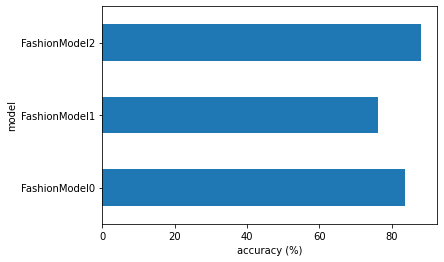

In [41]:
# Visualize our model results
comparison.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

# Random Predictions

In [42]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):

    pred_probs = []
    
    model.to(device)

    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

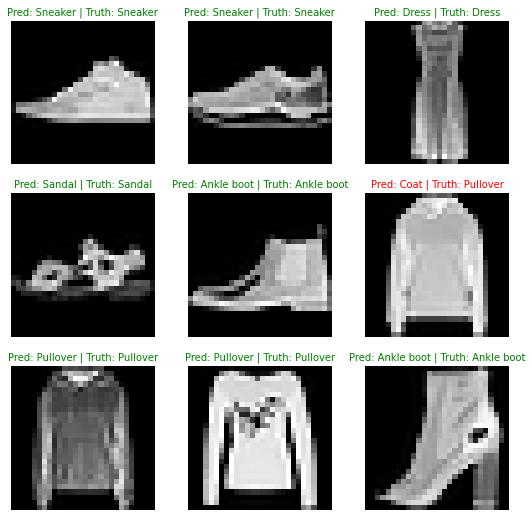

In [43]:
# pick random data from test dataset, make predictions, plot predictions

# pick 9 image-lable pairs from test_data
test_samples = [] 
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model=model2,  data=test_samples)
pred_classes = pred_probs.argmax(dim=1)


# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form) 
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r") 
  
  plt.axis(False);

## Confusion Matrix

In [45]:
# 1. Make predictions with trained model
y_preds = []
model2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 0, 1, 2])

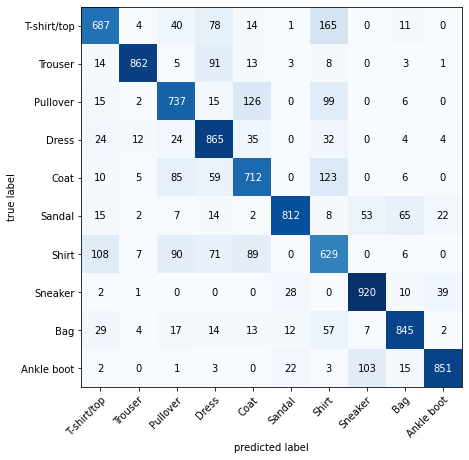

In [46]:
# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names,
    figsize=(10, 7)
)


# Saving Model

In [47]:
# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "computer-vision.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth
